In [2]:
import numpy as np
import math

# Naive Bayes

In [3]:
class NaiveBayes(object):
    """Naive Bayes Classifier (Gaussian)
    """

    def fit(self, x, y):
        # Fit parameters (Since continuous variables,
        # find mean, variance of each feature for each class)

        self.classes = np.unique(y)
        n_samples, n_features = np.shape(x)
        self.y = y
        self.parameters = []

        # Find parameters for each class        
        for i, c in enumerate(self.classes):
            # Filter datapoints belonging to ith class
            x_class = x[y == c]
            self.parameters.append([])
            # Iterate through each feature and find mean,variance
            for feature_i in range(n_features):
                parameters = {"mean":x_class[:, feature_i].mean(),  "var": x_class[:, feature_i].var()}
                self.parameters[i].append(parameters)
    
    def _calculate_prior(self, c):
        """Ratio of samples belonging to this class"""
        return len(self.y[self.y==c]) / len(self.y)

    def _calculate_likelihood(self, mean, var, x):
        """Return probability of lying on Gaussian defined by mean and var
        """
        eps = 1e-4
        coef = 1 / math.sqrt(2 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2)) / (2 * var + eps))
        return coef * exponent

    def _classify(self, x):
        """Assign sample to class with highest posterior probability
        P(Y|X) = P(X|Y) * P(Y) / P(X)
        P(X|Y): Likelihood of seeing data X given class Y
        P(Y): Prior (Ratio of samples belonging to this class)
        P(Y|X): Posterior likelihood: Probability of class Y given X
        Naive Bayes Assumption
        P(X1, X2, X3|Y) = P(X1|Y) * P(X2|Y) * P(X3|Y)
        """
        posteriors = []
        for i, c in enumerate(self.classes):
            # Compute prior for each class
            posterior = self._calculate_prior(c)

            # Compute likelihood of feature given each class
            # Get posterior = likelihood * prior for each class
            for params, feature_value in zip(self.parameters[i], x):
                posterior *= self._calculate_likelihood(params["mean"], params["var"], feature_value)
            posteriors.append(posterior)

        # Assign sample to the class with highest posterior probability 
        return self.classes[np.argmax(posteriors)]

    def predict(self, x):
        """Get class output
        """
        y_pred = [self._classify(sample) for sample in x]
        return np.array(y_pred)


Accuracy: 0.9123783031988874


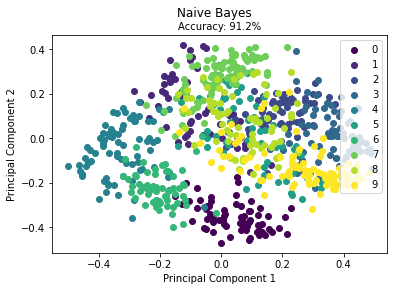

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def normalize(X, axis=-1, order=2):
    """Normalise the dataset (unit norm)
        Axis:0 => Each feature(column) is normalised to unit norm
        Axis:1 => Each sample(row) is normalised to unit norm
        X = X / sqrt(sum|X|^2)
    """
    norm = np.atleast_1d(np.linalg.norm(X, ord=order, axis=axis))
    norm[norm == 0] = 1
    return X / np.expand_dims(norm, axis=axis)

data = datasets.load_digits()
X = normalize(data.data)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = NaiveBayes()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

# Reduce dimension to two using PCA and plot the results
Plot().plot_in_2d(X_test, y_pred, title="Naive Bayes", accuracy=accuracy, legend_labels=data.target_names)

In [4]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()